---
---
# COVID-19 Vulnerability Index - First Steps
### By [Athon Millane](https://athonmillane.com)

---

#### The following is a minimal study exploring the feasibility of using patient comorbidity data (patient symptoms), to assess the patients risk for medical complications.
- Comorbidity tracks symptoms according to the [ICD-10](https://en.wikipedia.org/wiki/ICD-10) diagnosis codes that they present with. 
- This data in particular is a sample made available via [this work](https://github.com/closedloop-ai/cv19index) from ClosedLoop. 
- As far as I can tell they have purchased data licenses and have made available an open source repository with a data subset as well as a pretrained model hosted on SageMaker and a [commercial solution](https://closedloop.ai/cv19index/), trained on a larger proprietry dataset.
- While I'm investigating gaining access to this dataset, at present I'll make do with the 1000 case sample set.

#### It is important to note that this study does **not** directly use coronavirus data, as this is currently scarce in the public domain. It is rather an intersectional study of how different combinations of symptoms shape a persons risk of developing **complications** similar to those presented in severe cases of Coronavirus (i.e. **pnuemonia**).

In [2]:
%%capture
HOME  = '/home/jovyan' # change if working elsewhere
LOCAL = HOME+'/covid-comorbidity'

import os; os.chdir(LOCAL)
from src.manifold import *

---

## Let's visualise the latent space of patient comorbidities
- In this process, we take a highly sparse matrix of patient ICD codes broken down hierarchically.
- Without rigorously assessing the data, the subset focusses on patients who present with flu-like symptoms.
- According to the source of labels for our dataset, a person’s CV19 Index is measured in terms of their near-term risk of severe complications from respiratory infections (e.g. pneumonia, influenza).

In [3]:
gdf = cudf.read_csv('examples/xgboost/example_input.csv')

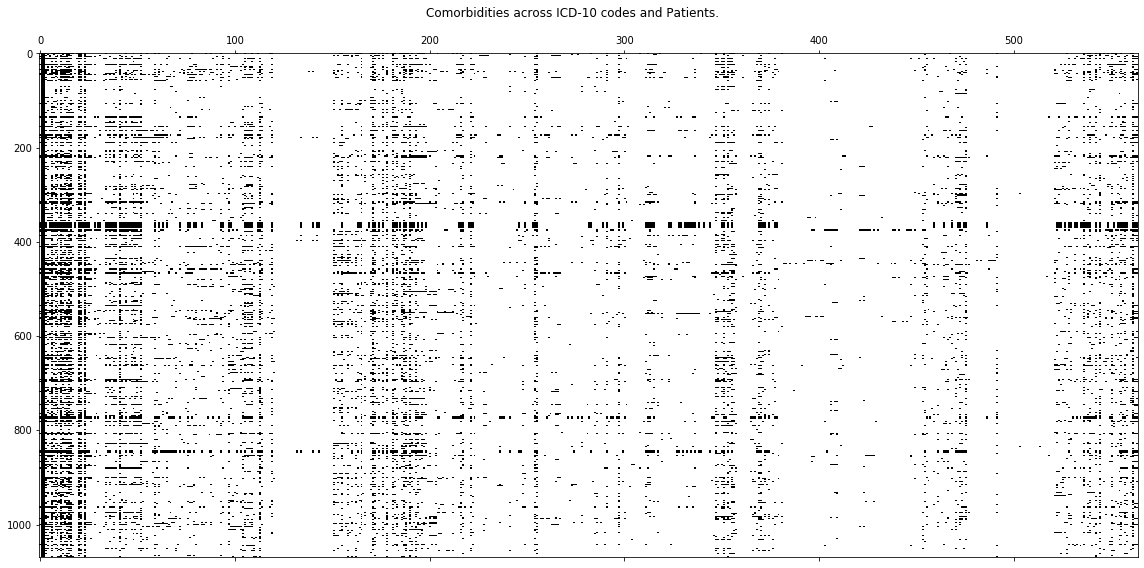

In [4]:
fig,ax=plt.subplots(1,1,figsize=[16,8])
fig.suptitle('Comorbidities across ICD-10 codes and Patients.')
ax.spy(gdf.drop('personId').to_pandas(), aspect='auto')
fig.tight_layout(); fig.subplots_adjust(top=0.9)

As expected, this matrix is very sparse, with some patients (rows) showing many more comorbidities and some showing fewer.

---

## Manifold Learning
In the following visualisation, we use 3 popular Machine Learning tools to visualise and understand the high dimensional relationships in our comorbidity matrix. The three techniques are:
- **PCA** - [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)
- **tSNE** - [t-Distributed Stochastic Neighbour Embedding](https://distill.pub/2016/misread-tsne/)
- **UMAP** - [Uniform Manifold Approximation and Projection](https://arxiv.org/pdf/1802.03426.pdf)

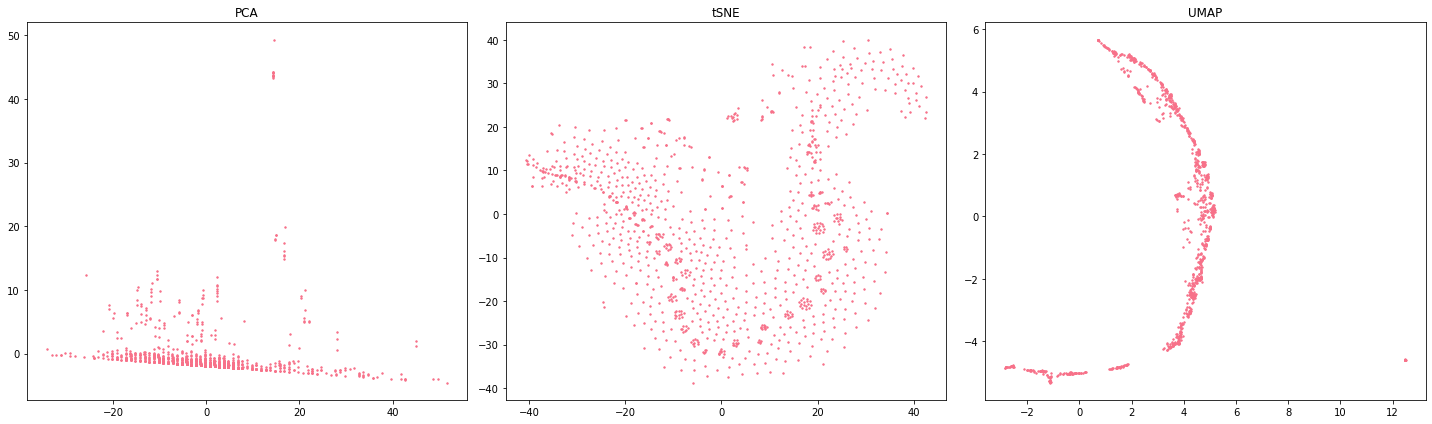

In [6]:
algos = {'PCA':PCA, 'tSNE':TSNE, 'UMAP':UMAP}
manifolds = [get_manifold_2d(gdf.drop('personId'), a) for a in algos.values()]
plot_manifolds(manifolds, algos.keys())

- This is a very promising result. With no knowledge of how comorbidity contributes to patient risk, a large amount of structure has been revealed in the data.
- The `PCA` approach plots the first two principle components, and while there is some separation in the dataset, there are important *non-linear* only revealed by nonlinear techniques.
- `tSNE` reveals a very nice clustering along a 'spine' in the manifold, with even distribution around the outside.
- `UMAP` does particularly well at identifying two large outlier clusters in the data, as well as a third larger cluster on the left. The thread-like property of the largest central cluster indicates a 1-dimensional manifold (distance-metric) has been found, in which an appropriate order can be assigned to points on this line.

---

## Incorporating Supervision
We incorporate the risk score metric determined from the labels of the dataset.
- Figures are replotted in larger format with the addition of colour to represent our label of interest - `patient risk score`.
- Patient risk is represented as a percentage from **0** to **100**, with **100** scoring patients at the highest risk.

In [7]:
gdf2 = cudf.read_csv('examples/xgboost/example_prediction.csv')

In [8]:
gdf[gdf.select_dtypes('bool').columns] = gdf.select_dtypes('bool').astype(int)
X = gdf.groupby('personId').mean()
y = gdf2.groupby('personId').mean()

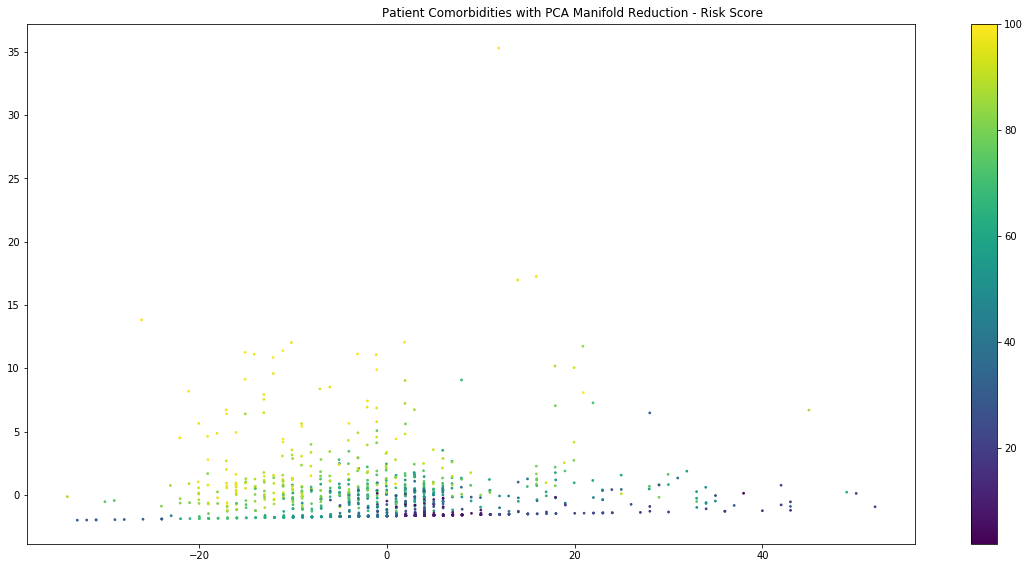

In [9]:
manifolds = [get_manifold_2d(X, a) for a in algos.values()]
m = manifolds[0].reset_index(drop=True).to_pandas()
label = y['risk_score'].to_pandas()
fig = plt.figure(figsize=[16,8])
fig.suptitle('Patient Comorbidities with PCA Manifold Reduction - Risk Score')
_=plt.scatter(m.values[:,0],m.values[:,1],alpha=1,s=3,c=label)
_=plt.colorbar(_); fig.tight_layout(); fig.subplots_adjust(top=0.95)

- An interesting observation of the PCA analysis is that a single principle component (the second) actually captures patient risk quite well.
- Higher risk patients typically sit at the highest regions of the `y-axis` and could feasibly be linearly separated, but not perfectly.

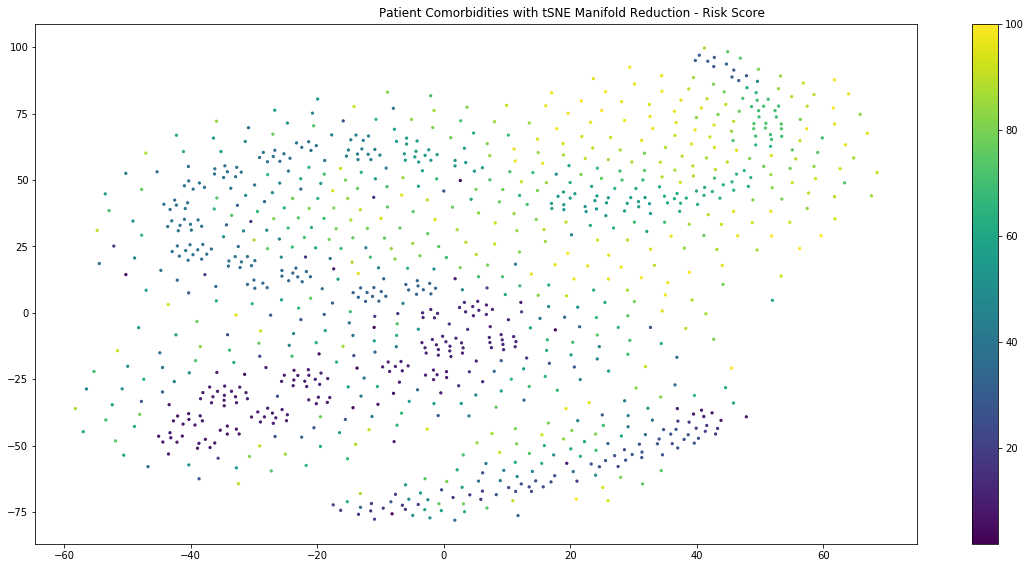

In [10]:
manifolds = [get_manifold_2d(X, a) for a in algos.values()]
m = manifolds[1].reset_index(drop=True).to_pandas()
label = y['risk_score'].to_pandas()
fig = plt.figure(figsize=[16,8])
fig.suptitle('Patient Comorbidities with tSNE Manifold Reduction - Risk Score')
_=plt.scatter(m.values[:,0],m.values[:,1],alpha=1,s=5,c=label)
_=plt.colorbar(_); fig.tight_layout(); fig.subplots_adjust(top=0.95)

- tSNE clustering makes perfect sense with the context of labels applied. We see really clean clusters of low-risk patients in the centre backbone, with highest risk (and least predictable - hence least clustered) patients at the fringes.

---

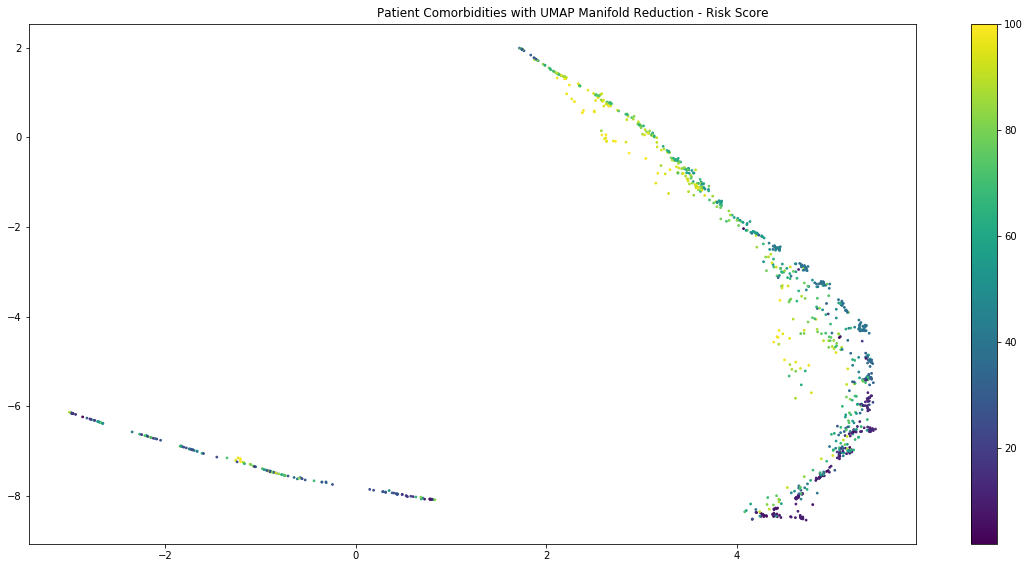

In [11]:
manifolds = [get_manifold_2d(X, a) for a in algos.values()]
m = manifolds[2].reset_index(drop=True).to_pandas()
label = y['risk_score'].to_pandas()
fig = plt.figure(figsize=[16,8])
fig.suptitle('Patient Comorbidities with UMAP Manifold Reduction - Risk Score')
_=plt.scatter(m.values[:,0],m.values[:,1],alpha=1,s=3,c=label)
_=plt.colorbar(_); fig.tight_layout(); fig.subplots_adjust(top=0.95)

- Unsupervised UMAP performs similarly well as tSNE. While arguably less pretty, very high risk patients (90-100%) are more cleanly clustered, shown as the yellow groups of points in the top right corner of the plot.

---

## Supervised UMAP
- To further demonstrate the power of manifold learning in understanding our comorbidity matrix, we can use a supervised version of `umap`.
- This works by incorporating label information (in this case binary, categorical) when constructing a manifold to sample from.
- The plots below demonstrate how UMAP separates data according to binary separations at multiple cutoff points -  `[10, 15, 25, 50, 75, 95] %`
- In all cases red captures the higher risk group and `blue` captures the lower risk group.

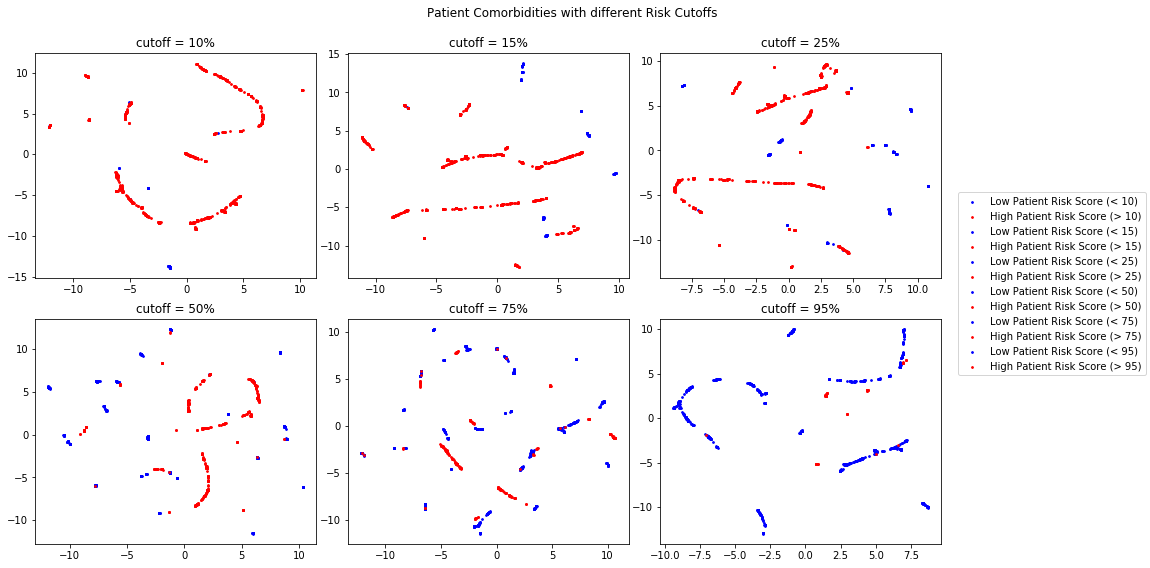

In [12]:
cutoffs = [10, 15, 25, 50, 75, 95]
fig,axs = plt.subplots(2,3,figsize=[16,8])
fig.suptitle('Patient Comorbidities with different Risk Cutoffs')
[supervised_umap(axs[i//3, i%3], manifolds, y, cutoff=c) for i,c in enumerate(cutoffs)]
fig.legend(loc='center right'); fig.tight_layout(); fig.subplots_adjust(top=0.9, right=0.82)

#### These results are really promising for the ability to extend and infer risk with new patients presenting with symptoms.
- With a cutoff of 15%, all lowest risk patients appear to be separable. **In a traige situation, this might constitute the group of patients to send home.**
- With a partition of the data 50% patient risk, 2 fairly clean manifolds result, with a very small scattering of high risk clusters connected to low risk clusters. **In a triage situation, this gives a clear indicator of who to treat first.**
- With cutoffs of both 75% and 95%, the most at risk patients are cleanly grouped together in a number of small clusters. **In a triage situation, patients presenting with this list of symptoms (comorbidities) would be priorities, potentiall taken directly to ICU for intubation or treatment.**

---
---